In [ ]:
!pip install transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer, BertForQuestionAnswering
import torch
from datasets import load_dataset

squad_v2 = load_dataset("squad_v2")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

In [ ]:
from transformers import BertTokenizer

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize a sample
sample = squad_v2['train'][0]
tokenized_sample = tokenizer(
    sample['question'],
    sample['context'],
    max_length=512,
    truncation="only_second",  # Truncate only the context, not the question
    padding="max_length",
    return_tensors="pt"
)
print(sample)


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

{'id': '56be85543aeaaa14008c9063', 'title': 'Beyoncé', 'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".', 'question': 'When did Beyonce start becoming popular?', 'answers': {'text': ['in the late 1990s'], 'answer_start': [269]}}


In [ ]:
for entry in squad_v2['train'][:10]:
  print(entry)

id
title
context
question
answers


In [ ]:
print(type(squad_v2['train'][0]))  # This should print <class 'dict'> if the entry is a dictionary
print(squad_v2['train'][0])



<class 'dict'>
{'id': '56be85543aeaaa14008c9063', 'title': 'Beyoncé', 'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".', 'question': 'When did Beyonce start becoming popular?', 'answers': {'text': ['in the late 1990s'], 'answer_start': [269]}}


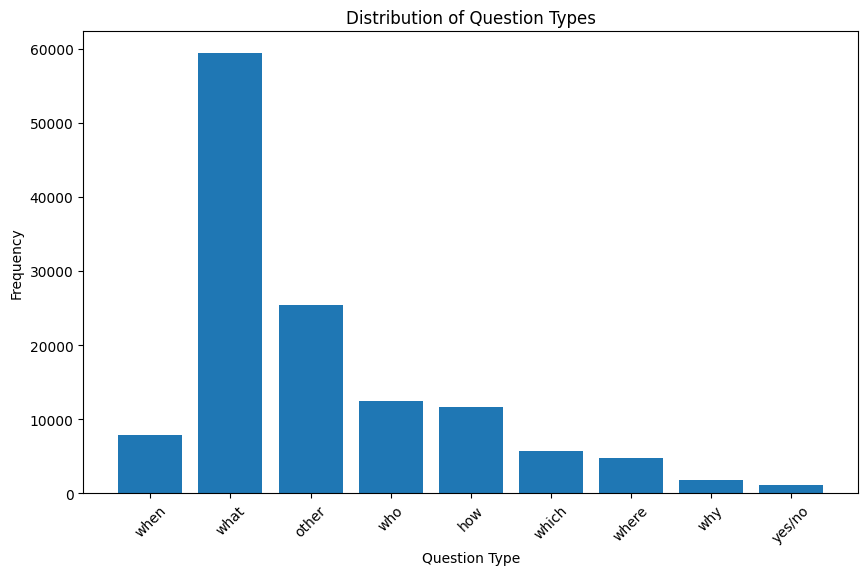

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Assuming `squad_v2` is loaded and contains the 'question' field
question_types = ['what', 'who', 'where', 'how', 'when', 'which', 'why', 'yes/no']

# Initialize a Counter object to store question type frequencies
question_type_counter = Counter()

# Loop through each entry and count the question types
for entry in squad_v2['train']:
    question = entry['question'].lower().split()
    # Check if the first word of the question is in our question types
    if question[0] in question_types:
        question_type_counter[question[0]] += 1
    else:
        question_type_counter['yes/no' if question[0] in ['is', 'are', 'was', 'were', 'do', 'does', 'did', 'can', 'could', 'has', 'have', 'should', 'would'] else 'other'] += 1

# Now, create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(question_type_counter.keys(), question_type_counter.values())
plt.title('Distribution of Question Types')
plt.xlabel('Question Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


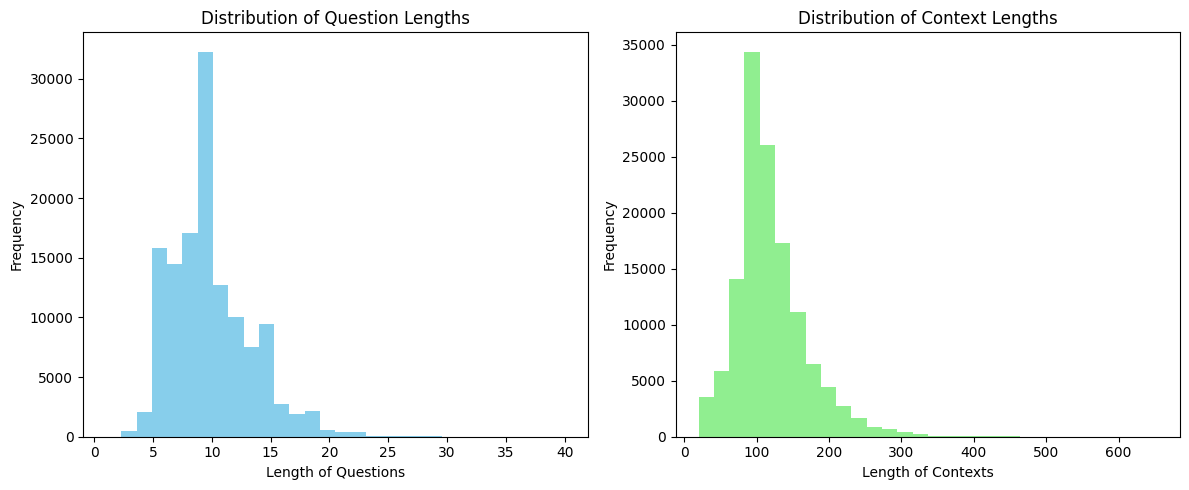

In [ ]:
#I am getting the length of each question in my training set
#I am getting the length of each context in my training set
context_length = []
question_length = []
for entry in squad_v2['train']:
  question_array = entry['question'].split()
  question_length.append(len(question_array))
  context_array = entry['context'].split()
  context_length.append(len(context_array))
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(question_length, bins=30, color='skyblue')
plt.title('Distribution of Question Lengths')
plt.xlabel('Length of Questions')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(context_length, bins=30, color='lightgreen')
plt.title('Distribution of Context Lengths')
plt.xlabel('Length of Contexts')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



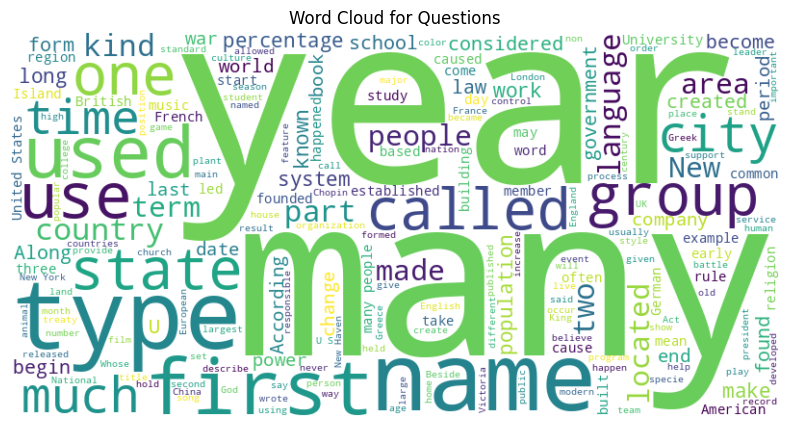

In [ ]:
#wordcloud visualization
!pip install wordcloud
from wordcloud import WordCloud
all_questions = ' '
for entry in squad_v2['train']:
  all_questions += entry['question']
wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate(all_questions)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Questions')
plt.show()





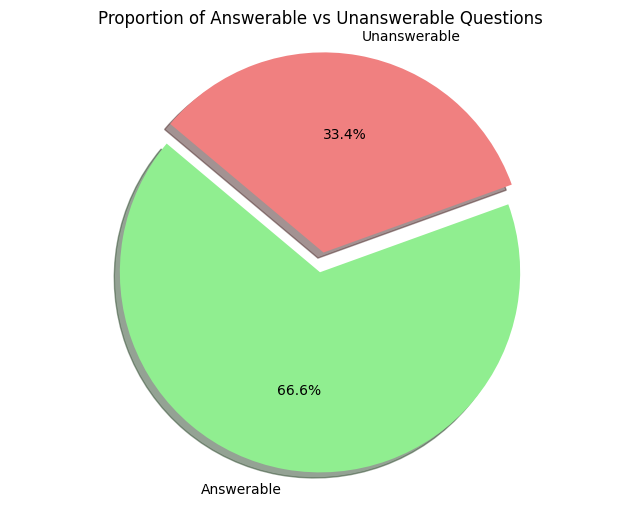

In [ ]:
answerable_count = 0
unanswerable_count = 0

for entry in squad_v2['train']:
    if entry['answers']['text']:
        answerable_count += 1
    else:
        unanswerable_count += 1
labels = 'Answerable', 'Unanswerable'
sizes = [answerable_count, unanswerable_count]
colors = ['lightgreen', 'lightcoral']
explode = (0.1, 0)
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Proportion of Answerable vs Unanswerable Questions')
plt.show()



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


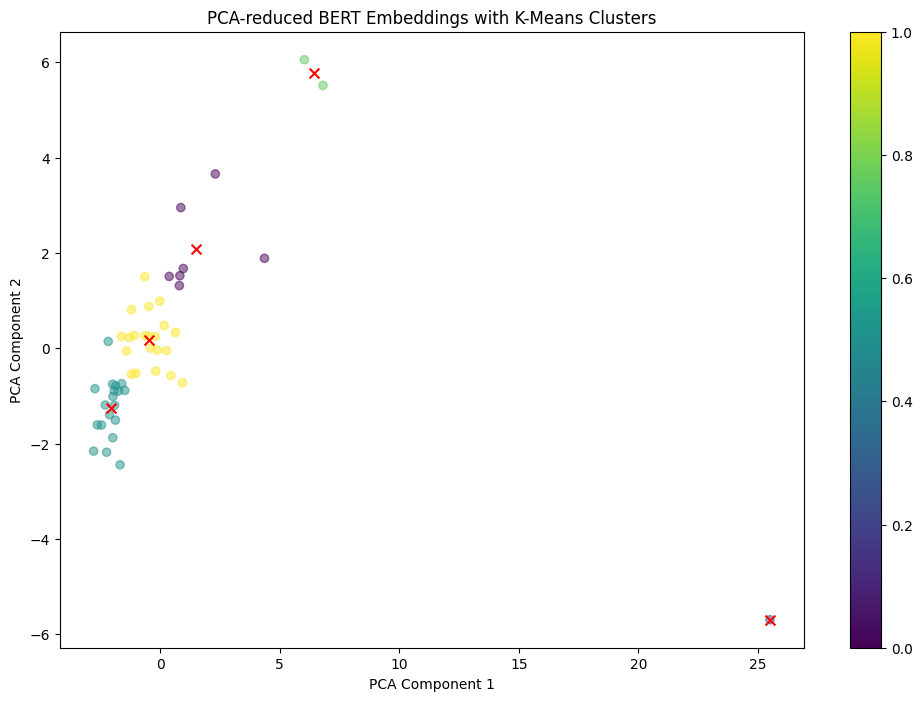

In [ ]:
import numpy as np
from transformers import BertTokenizer, BertModel
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Initialize the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to encode a batch of context and questions and extract embeddings
def batch_encode_and_extract_embeddings(tokenizer, model, contexts, questions, max_length=512):
    # Tokenize and encode the batch
    inputs = tokenizer(contexts, questions, padding=True, truncation=True, max_length=max_length, return_tensors="pt")

    # Move to GPU if available
    inputs = {key: val.to(model.device) for key, val in inputs.items()}

    # Get BERT embeddings
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # Get the embeddings for the [CLS] token
    return embeddings

# Choose a random sample of 50 entries from the dataset
sample_size = 50
indices = np.random.choice(len(squad_v2['train']), size=sample_size, replace=False)

# Convert NumPy int64 types to standard Python ints for indexing
sampled_entries = [squad_v2['train'][int(i)] for i in indices]

# Extract contexts and questions
contexts = [entry['context'] for entry in sampled_entries]
questions = [entry['question'] for entry in sampled_entries]

# Get BERT embeddings for the batch
embeddings = batch_encode_and_extract_embeddings(tokenizer, model, contexts, questions)

# Apply PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # Adjust the number of clusters as necessary
kmeans_labels = kmeans.fit_predict(reduced_embeddings)

# Visualization
plt.figure(figsize=(12, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.5)
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50, marker='x')  # Mark the centroids
plt.title('PCA-reduced BERT Embeddings with K-Means Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()


In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Perform PCA with 2 components
pca_2 = PCA(n_components=2)
reduced_embeddings_2 = pca_2.fit_transform(embeddings)

# Perform PCA with 3 components
pca_3 = PCA(n_components=3)
reduced_embeddings_3 = pca_3.fit_transform(embeddings)

# Apply K-Means clustering to the 2-component reduced data
kmeans_2 = KMeans(n_clusters=5, random_state=42)
clusters_2 = kmeans_2.fit_predict(reduced_embeddings_2)

# Apply K-Means clustering to the 3-component reduced data
kmeans_3 = KMeans(n_clusters=5, random_state=42)
clusters_3 = kmeans_3.fit_predict(reduced_embeddings_3)

# Apply DBSCAN clustering to the 2-component reduced data
dbs_cluster_2 = DBSCAN(eps=2.5, min_samples=4)

dbs_labels_2 = dbs_cluster_2.fit(reduced_embeddings_2).labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(dbs_labels_2)) - (1 if -1 in dbs_labels_2 else 0)
n_noise_ = list(dbs_labels_2).count(-1)

# Apply DBSCAN clustering to the 3-component reduced data
dbs_cluster_3 = DBSCAN(eps=2.5, min_samples=6)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


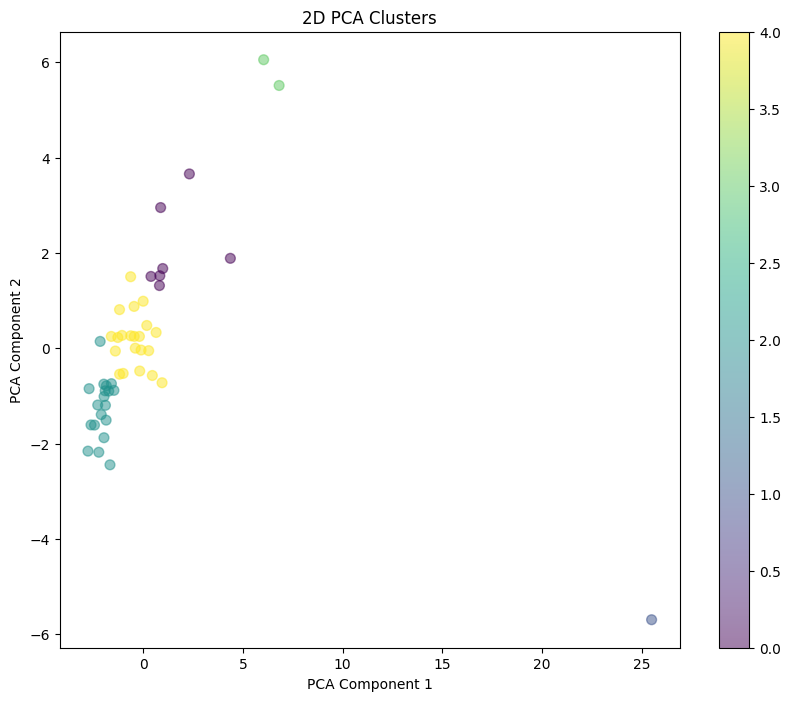

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings_2[:, 0], reduced_embeddings_2[:, 1], c=clusters_2, cmap='viridis', alpha=0.5, s=50)  # increased size
plt.title('2D PCA Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()



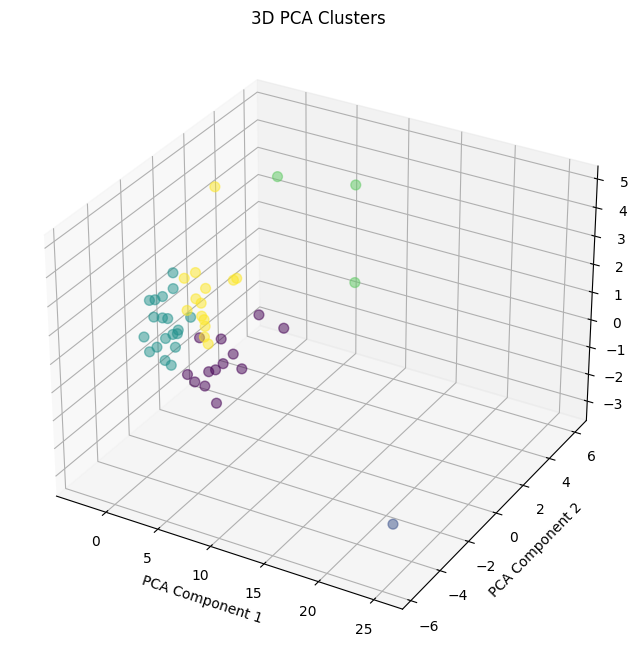

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reduced_embeddings_3[:, 0], reduced_embeddings_3[:, 1], reduced_embeddings_3[:, 2], c=clusters_3, cmap='viridis', alpha=0.5, s=50)  # increased size
ax.set_title('3D PCA Clusters')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.show()



Text(0.5, 1.0, 'Points Sorted by Distance to 2*MinPts Nearest Neighbor')

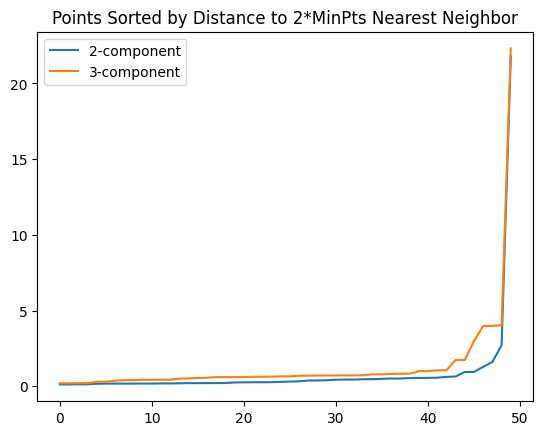

In [ ]:
# Use elbow method to determine epsilon for each DBSCAN clustering
# 2-component
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(reduced_embeddings_2)
distances, indices = neighbors_fit.kneighbors(reduced_embeddings_2)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

# 3-component
neighbors = NearestNeighbors(n_neighbors=6)
neighbors_fit = neighbors.fit(reduced_embeddings_3)
distances, indices = neighbors_fit.kneighbors(reduced_embeddings_3)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.legend(['2-component', '3-component'])
plt.title("Points Sorted by Distance to 2*MinPts Nearest Neighbor")

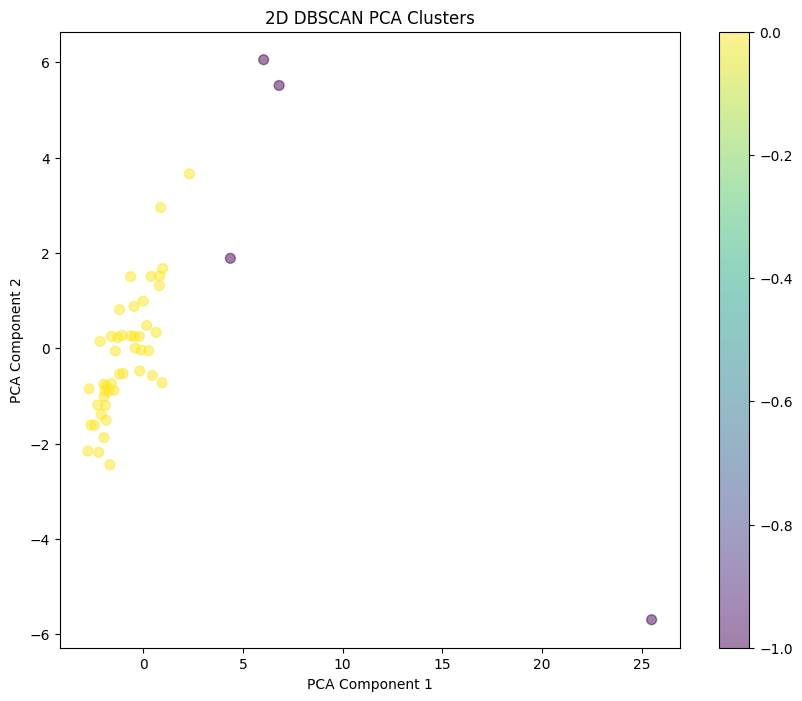

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings_2[:, 0], reduced_embeddings_2[:, 1], c=dbs_cluster_2.fit_predict(reduced_embeddings_2), cmap='viridis', alpha=0.5, s=50)  # increased size
plt.title('2D DBSCAN PCA Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()

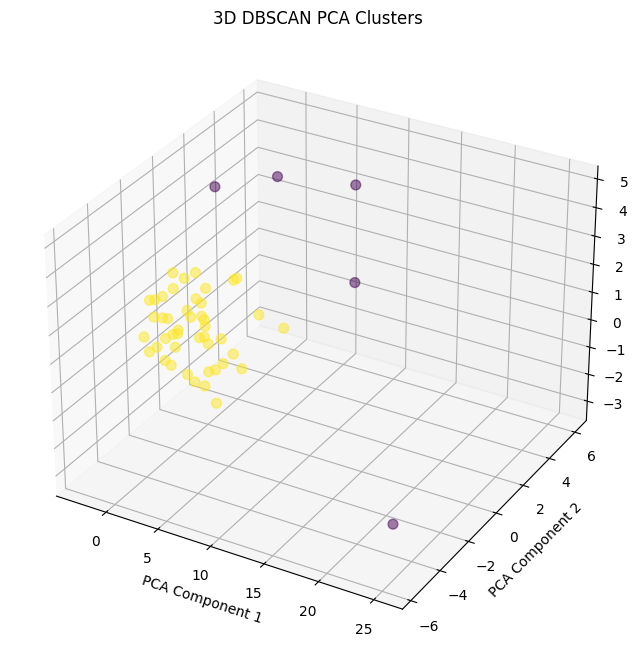

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reduced_embeddings_3[:, 0], reduced_embeddings_3[:, 1], reduced_embeddings_3[:, 2], c=dbs_cluster_3.fit_predict(reduced_embeddings_3), cmap='viridis', alpha=0.5, s=50)  # increased size
ax.set_title('3D DBSCAN PCA Clusters')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.show()

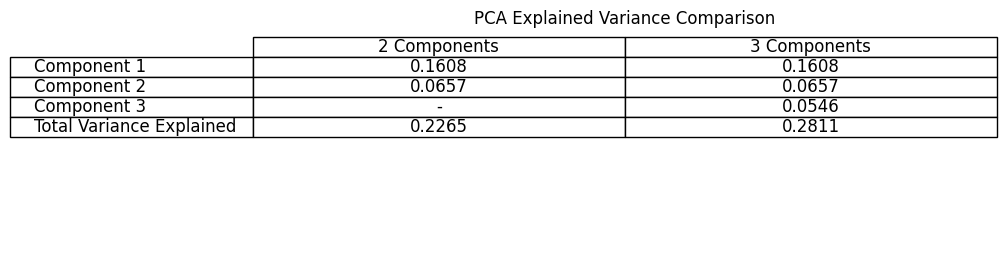

In [ ]:
explained_variance_2 = pca_2.explained_variance_ratio_
explained_variance_3 = pca_3.explained_variance_ratio_
# Data for table comparison
cell_text = [
    [f"{explained_variance_2[0]:.4f}", f"{explained_variance_3[0]:.4f}"],
    [f"{explained_variance_2[1]:.4f}", f"{explained_variance_3[1]:.4f}"],
    ["-", f"{explained_variance_3[2]:.4f}"],
    [f"{sum(explained_variance_2):.4f}", f"{sum(explained_variance_3):.4f}"]
]

# Create the table plot
fig, ax = plt.subplots(figsize=(8, 3))
ax.set_axis_off()
table = ax.table(
    cellText=cell_text,
    colLabels=['2 Components', '3 Components'],
    rowLabels=['Component 1', 'Component 2', 'Component 3', 'Total Variance Explained'],
    cellLoc = 'center',
    loc='upper center'
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
plt.title('PCA Explained Variance Comparison')

plt.show()


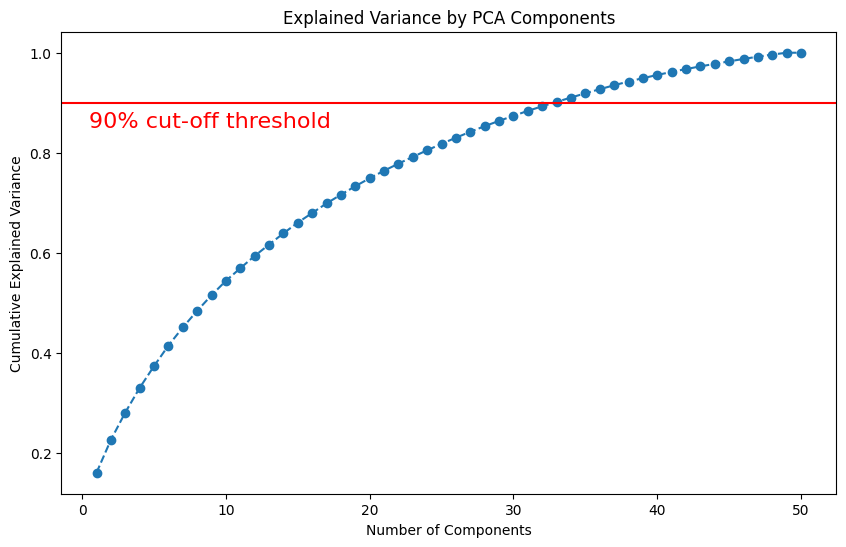

Number of components explaining 90% variance: 33


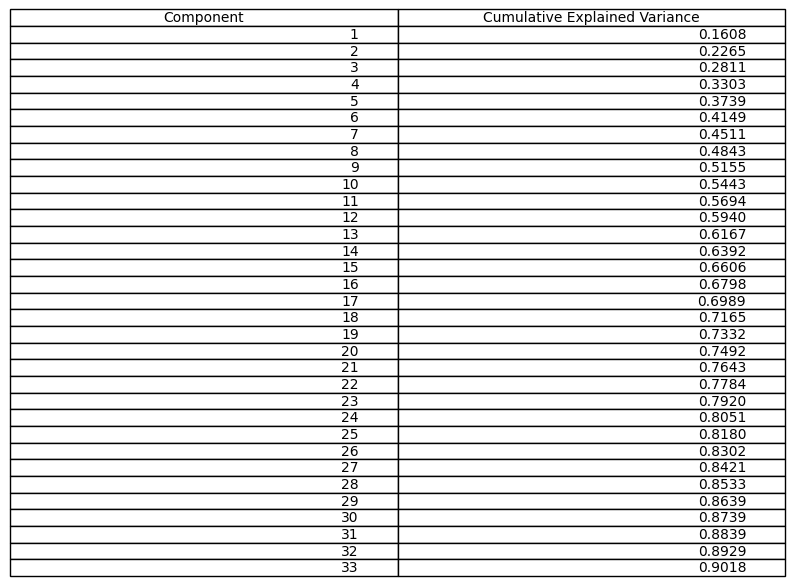

In [ ]:
# Start with the number of components equal to the minimum of the number of samples and features
n_components = min(len(embeddings), len(embeddings[0]))
pca = PCA(n_components=n_components)
pca.fit(embeddings)

# Find the number of components needed to explain at least 90% of the variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
num_components_for_90 = np.where(cumulative_variance >= 0.90)[0][0] + 1  # Indexing starts at 0

# Now you can generate a scree plot to visualize the explained variance ratio for each component
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.90, color='r', linestyle='-')
plt.text(0.5, 0.85, '90% cut-off threshold', color = 'red', fontsize=16)
plt.show()

# Print the number of components that explain at least 90% of the variance
print(f"Number of components explaining 90% variance: {num_components_for_90}")

# If you want to generate a table of explained variances for each component
# up to the number that gives you 90% of the variance
components = list(range(1, num_components_for_90 + 1))
explained_variance_data = cumulative_variance[:num_components_for_90]

# Create a table of explained variances
fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('tight')
ax.axis('off')
table_data = [[comp, f"{var:.4f}"] for comp, var in zip(components, explained_variance_data)]
ax.table(cellText=table_data, colLabels=['Component', 'Cumulative Explained Variance'], loc='center')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Extracting answerable and unanswerable samples for the training set
answerable_samples_train = [entry for entry in squad_v2['train'] if entry['answers']['text']][:50]
unanswerable_samples_train = [entry for entry in squad_v2['train'] if not entry['answers']['text']][:50]

# Extracting random samples for the test set
random_samples_test = np.random.choice(squad_v2['train'], size=20, replace=False)

# Combine the training lists and shuffle them
all_samples_train = answerable_samples_train + unanswerable_samples_train
np.random.shuffle(all_samples_train)

# Generate labels for the training samples
labels_train = [1 if entry in answerable_samples_train else 0 for entry in all_samples_train]

# Generate embeddings for the training samples
contexts_train = [entry['context'] for entry in all_samples_train]
questions_train = [entry['question'] for entry in all_samples_train]
embeddings_train = batch_encode_and_extract_embeddings(tokenizer, model, contexts_train, questions_train)

# Generate embeddings for the test samples
contexts_test = [entry['context'] for entry in random_samples_test]
questions_test = [entry['question'] for entry in random_samples_test]
labels_test = [1 if entry['answers']['text'] else 0 for entry in random_samples_test]
embeddings_test = batch_encode_and_extract_embeddings(tokenizer, model, contexts_test, questions_test)

# Initialize the Logistic Regression classifier
classifier = LogisticRegression(max_iter=1000)

# Train the classifier with the training data
classifier.fit(embeddings_train, labels_train)

# Predict on the test set
y_pred = classifier.predict(embeddings_test)

# Evaluate the model
print("Accuracy on test set:", accuracy_score(labels_test, y_pred))
print(classification_report(labels_test, y_pred))


Accuracy on test set: 0.5
              precision    recall  f1-score   support

           0       0.50      0.90      0.64        10
           1       0.50      0.10      0.17        10

    accuracy                           0.50        20
   macro avg       0.50      0.50      0.40        20
weighted avg       0.50      0.50      0.40        20



In [ ]:
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import torch
import numpy as np

# Load the dataset
squad_v2 = load_dataset("squad_v2")

# Initialize the tokenizer and model from HuggingFace Transformers
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to encode and extract embeddings for the dataset
def encode_and_extract_embeddings(dataset, batch_size=16):
    # Use the GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    embeddings = []
    for i in range(0, len(dataset), batch_size):
        batch = dataset[i:i+batch_size]
        contexts = [entry['context'] for entry in batch]
        questions = [entry['question'] for entry in batch]
        # Tokenize and encode the batch
        inputs = tokenizer(contexts, questions, padding=True, truncation=True, max_length=512, return_tensors="pt")
        inputs = inputs.to(device)

        # Get BERT embeddings
        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

# Create labels
labels = [1 if entry['answers']['text'] else 0 for entry in squad_v2['train']]

# We'll use a smaller portion of the data to avoid memory issues
# Convert numpy.int64 indices to native Python ints
sample_indices = [int(i) for i in np.random.choice(len(squad_v2['train']), size=2000, replace=False)]

# Now it's safe to use these indices to sample the dataset
sampled_dataset = [squad_v2['train'][i] for i in sample_indices]
sampled_labels = [labels[i] for i in sample_indices]


# Extract embeddings for the sampled data
embeddings = encode_and_extract_embeddings(sampled_dataset)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(embeddings, sampled_labels, test_size=0.2, random_state=42)

# Initialize the Logistic Regression classifier
classifier = LogisticRegression(max_iter=1000)

# Train the classifier
classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Accuracy: 0.655
              precision    recall  f1-score   support

           0       0.45      0.48      0.47       126
           1       0.75      0.74      0.75       274

    accuracy                           0.66       400
   macro avg       0.60      0.61      0.61       400
weighted avg       0.66      0.66      0.66       400



In [ ]:
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
import torch
import numpy as np


# Load the dataset
squad_v2 = load_dataset("squad_v2")

# Initialize the tokenizer and model from HuggingFace Transformers
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to encode and extract embeddings for the dataset
def encode_and_extract_embeddings(dataset, batch_size=16):
    # Use the GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    embeddings = []
    for i in range(0, len(dataset), batch_size):
        batch = dataset[i:i+batch_size]
        contexts = [entry['context'] for entry in batch]
        questions = [entry['question'] for entry in batch]
        # Tokenize and encode the batch
        inputs = tokenizer(contexts, questions, padding=True, truncation=True, max_length=512, return_tensors="pt")
        inputs = inputs.to(device)

        # Get BERT embeddings
        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

# Create labels
labels = [1 if entry['answers']['text'] else 0 for entry in squad_v2['train']]

# We'll use a smaller portion of the data to avoid memory issues
# Convert numpy.int64 indices to native Python ints
sample_indices = [int(i) for i in np.random.choice(len(squad_v2['train']), size=2000, replace=False)]

# Now it's safe to use these indices to sample the dataset
sampled_dataset = [squad_v2['train'][i] for i in sample_indices]
sampled_labels = [labels[i] for i in sample_indices]


# Extract embeddings for the sampled data
embeddings = encode_and_extract_embeddings(sampled_dataset)

# Reduce the dimension of the data
pca_33 = PCA(n_components=33)
reduced_embeddings_33 = pca_33.fit_transform(embeddings)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(reduced_embeddings_33, sampled_labels, test_size=0.2, random_state=42)

# Initialize the Logistic Regression classifier
classifier = LogisticRegression(max_iter=1000)

# Train the classifier
classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Accuracy: 0.6475
              precision    recall  f1-score   support

           0       0.48      0.21      0.29       138
           1       0.68      0.88      0.77       262

    accuracy                           0.65       400
   macro avg       0.58      0.54      0.53       400
weighted avg       0.61      0.65      0.60       400



In [ ]:
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import torch
import numpy as np

# Load the dataset
squad_v2 = load_dataset("squad_v2")

# Initialize the tokenizer and model from HuggingFace Transformers
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to encode and extract embeddings for the dataset
def encode_and_extract_embeddings(dataset, batch_size=16):
    # Use the GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    embeddings = []
    for i in range(0, len(dataset), batch_size):
        batch = dataset[i:i+batch_size]
        contexts = [entry['context'] for entry in batch]
        questions = [entry['question'] for entry in batch]
        # Tokenize and encode the batch
        inputs = tokenizer(contexts, questions, padding=True, truncation=True, max_length=512, return_tensors="pt")
        inputs = inputs.to(device)

        # Get BERT embeddings
        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

# Create labels
labels = [1 if entry['answers']['text'] else 0 for entry in squad_v2['train']]

# We'll use a smaller portion of the data to avoid memory issues
# Convert numpy.int64 indices to native Python ints
sample_indices = [int(i) for i in np.random.choice(len(squad_v2['train']), size=2000, replace=False)]

# Now it's safe to use these indices to sample the dataset
sampled_dataset = [squad_v2['train'][i] for i in sample_indices]
sampled_labels = [labels[i] for i in sample_indices]


# Extract embeddings for the sampled data
embeddings = encode_and_extract_embeddings(sampled_dataset)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(embeddings, sampled_labels, test_size=0.2, random_state=42)

# Initialize random forest
clf = RandomForestClassifier(n_estimators=200, max_depth=65, max_features=65)

#train random forest
clf.fit(X_train, y_train)

#test forest
y_pred = clf.predict(X_test)

# Evaluate the model
print("Cross Validation Score:", cross_val_score(clf, X_train, y_train))
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Cross Validation Score: [0.675    0.703125 0.7      0.69375  0.7     ]
Accuracy: 0.65
              precision    recall  f1-score   support

           0       0.67      0.06      0.10       144
           1       0.65      0.98      0.78       256

    accuracy                           0.65       400
   macro avg       0.66      0.52      0.44       400
weighted avg       0.66      0.65      0.54       400



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


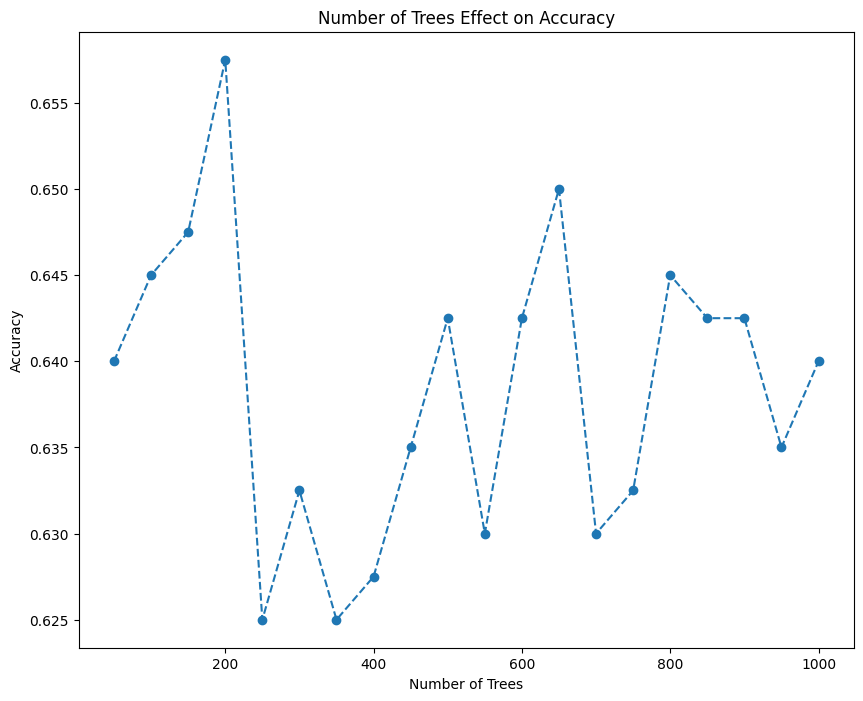

In [ ]:
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import torch
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
squad_v2 = load_dataset("squad_v2")

# Initialize the tokenizer and model from HuggingFace Transformers
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to encode and extract embeddings for the dataset
def encode_and_extract_embeddings(dataset, batch_size=16):
    # Use the GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    embeddings = []
    for i in range(0, len(dataset), batch_size):
        batch = dataset[i:i+batch_size]
        contexts = [entry['context'] for entry in batch]
        questions = [entry['question'] for entry in batch]
        # Tokenize and encode the batch
        inputs = tokenizer(contexts, questions, padding=True, truncation=True, max_length=512, return_tensors="pt")
        inputs = inputs.to(device)

        # Get BERT embeddings
        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

# Create labels
labels = [1 if entry['answers']['text'] else 0 for entry in squad_v2['train']]

# We'll use a smaller portion of the data to avoid memory issues
# Convert numpy.int64 indices to native Python ints
sample_indices = [int(i) for i in np.random.choice(len(squad_v2['train']), size=2000, replace=False)]

# Now it's safe to use these indices to sample the dataset
sampled_dataset = [squad_v2['train'][i] for i in sample_indices]
sampled_labels = [labels[i] for i in sample_indices]


# Extract embeddings for the sampled data
embeddings = encode_and_extract_embeddings(sampled_dataset)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(embeddings, sampled_labels, test_size=0.2, random_state=42)

#Initialize list of max depths to test
tree_numbers = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]

results = []
#test number of trees
for number_of_trees in tree_numbers:

  # Initialize random forest
  clf = RandomForestClassifier(n_estimators=number_of_trees)

  #train random forest
  clf.fit(X_train, y_train)

  #test forest
  y_pred = clf.predict(X_test)

  # Evaluate the model
  results.append(accuracy_score(y_test, y_pred))
plt.figure(figsize=(10, 8))
plt.plot(tree_numbers, results, linestyle='dashed', marker="o")  # increased size
plt.title('Number of Trees Effect on Accuracy')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.show()

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


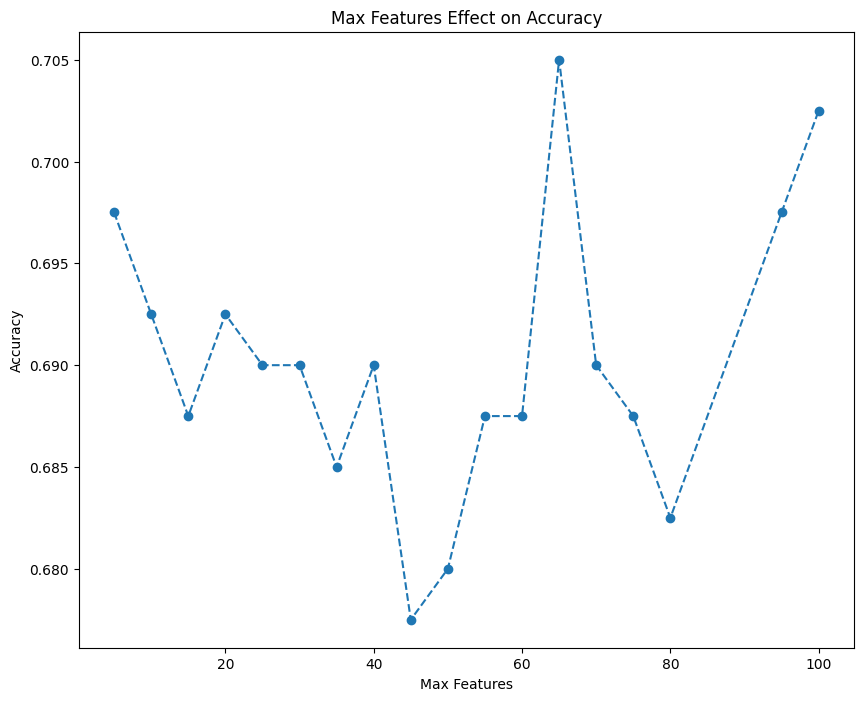

In [ ]:
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import torch
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
squad_v2 = load_dataset("squad_v2")

# Initialize the tokenizer and model from HuggingFace Transformers
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to encode and extract embeddings for the dataset
def encode_and_extract_embeddings(dataset, batch_size=16):
    # Use the GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    embeddings = []
    for i in range(0, len(dataset), batch_size):
        batch = dataset[i:i+batch_size]
        contexts = [entry['context'] for entry in batch]
        questions = [entry['question'] for entry in batch]
        # Tokenize and encode the batch
        inputs = tokenizer(contexts, questions, padding=True, truncation=True, max_length=512, return_tensors="pt")
        inputs = inputs.to(device)

        # Get BERT embeddings
        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

# Create labels
labels = [1 if entry['answers']['text'] else 0 for entry in squad_v2['train']]

# We'll use a smaller portion of the data to avoid memory issues
# Convert numpy.int64 indices to native Python ints
sample_indices = [int(i) for i in np.random.choice(len(squad_v2['train']), size=2000, replace=False)]

# Now it's safe to use these indices to sample the dataset
sampled_dataset = [squad_v2['train'][i] for i in sample_indices]
sampled_labels = [labels[i] for i in sample_indices]


# Extract embeddings for the sampled data
embeddings = encode_and_extract_embeddings(sampled_dataset)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(embeddings, sampled_labels, test_size=0.2, random_state=42)

#Initialize list of max features to test
max_features_list = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,95,100]

results = []
#test different max features
for max_features in max_features_list:

  # Initialize random forest
  clf = RandomForestClassifier(max_depth=max_features, max_features=max_features)

  #train random forest
  clf.fit(X_train, y_train)

  #test forest
  y_pred = clf.predict(X_test)

  # Evaluate the model
  results.append(accuracy_score(y_test, y_pred))
plt.figure(figsize=(10, 8))
plt.plot(max_features_list, results, linestyle='dashed', marker="o")  # increased size
plt.title('Max Features Effect on Accuracy')
plt.xlabel('Max Features')
plt.ylabel('Accuracy')
plt.show()


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Cross Validation Score: [0.675    0.665625 0.671875 0.671875 0.665625]
Accuracy: 0.6925
              precision    recall  f1-score   support

           0       0.50      0.01      0.02       123
           1       0.69      1.00      0.82       277

    accuracy                           0.69       400
   macro avg       0.60      0.50      0.42       400
weighted avg       0.63      0.69      0.57       400



NameError: ignored

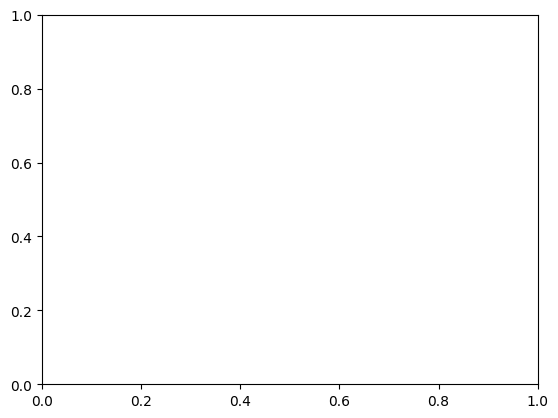

In [ ]:
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn import svm
import torch
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
squad_v2 = load_dataset("squad_v2")

# Initialize the tokenizer and model from HuggingFace Transformers
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to encode and extract embeddings for the dataset
def encode_and_extract_embeddings(dataset, batch_size=16):
    # Use the GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    embeddings = []
    for i in range(0, len(dataset), batch_size):
        batch = dataset[i:i+batch_size]
        contexts = [entry['context'] for entry in batch]
        questions = [entry['question'] for entry in batch]
        # Tokenize and encode the batch
        inputs = tokenizer(contexts, questions, padding=True, truncation=True, max_length=512, return_tensors="pt")
        inputs = inputs.to(device)

        # Get BERT embeddings
        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

# Create labels
labels = [1 if entry['answers']['text'] else 0 for entry in squad_v2['train']]

# We'll use a smaller portion of the data to avoid memory issues
# Convert numpy.int64 indices to native Python ints
sample_indices = [int(i) for i in np.random.choice(len(squad_v2['train']), size=2000, replace=False)]

# Now it's safe to use these indices to sample the dataset
sampled_dataset = [squad_v2['train'][i] for i in sample_indices]
sampled_labels = [labels[i] for i in sample_indices]


# Extract embeddings for the sampled data
embeddings = encode_and_extract_embeddings(sampled_dataset)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(embeddings, sampled_labels, test_size=0.2, random_state=42)

# Initialize random forest
clf = svm.SVC()

#train random forest
clf.fit(X_train, y_train)

#test forest
y_pred = clf.predict(X_test)

# Evaluate the model
print("Cross Validation Score:", cross_val_score(clf, X_train, y_train))
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = X_test[:, 0], X_test[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('y label here')
ax.set_xlabel('x label here')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
ax.legend()
plt.show()

In [ ]:
#Neural Network
!pip install transformers

In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
from transformers import BertTokenizerFast


In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')


In [ ]:
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O squad_train_v2.json
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O squad_dev_v2.json


--2023-12-06 19:41:34--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘squad_train_v2.json’

squad_train_v2.json 100%[===================>]  40.17M   199MB/s    in 0.2s    

2023-12-06 19:41:34 (199 MB/s) - ‘squad_train_v2.json’ saved [42123633/42123633]

--2023-12-06 19:41:34--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘squad_dev_v2.json’

squad_dev

In [ ]:

import json

# Function to load the dataset
def load_squad(path):
    with open(path, 'r') as file:
        squad_data = json.load(file)
    return squad_data

# Load training and development data
squad_train = load_squad('squad_train_v2.json')
squad_dev = load_squad('squad_dev_v2.json')


In [ ]:
def tokenize_squad(data, tokenizer):
    tokenized_data = []
    for article in data['data']:
        for paragraph in article['paragraphs']:
            context = paragraph['context']
            for qa in paragraph['qas']:
                question = qa['question']
                # Tokenize context and question
                tokenized_example = tokenizer.encode_plus(question, context, max_length=512, truncation='only_second', padding='max_length', return_tensors='tf')

                # Check if the question is answerable
                is_answerable = 1 if 'answers' in qa and len(qa['answers']) > 0 else 0

                # Store tokenized data with binary label
                tokenized_data.append({
                    'input_ids': tokenized_example['input_ids'].numpy()[0],
                    'attention_mask': tokenized_example['attention_mask'].numpy()[0],
                    'token_type_ids': tokenized_example['token_type_ids'].numpy()[0],
                    'label': is_answerable
                })
    return tokenized_data


In [ ]:
tokenized_train = tokenize_squad(squad_train, tokenizer)
tokenized_dev = tokenize_squad(squad_dev, tokenizer)


In [ ]:
import random

def tokenize_squad(data, tokenizer, subset_fraction=1):
    # Prepare a list to store tokenized data
    tokenized_data = []

    # Prepare a list to collect all data before sampling
    all_data = []

    # Iterate through the dataset and collect all examples
    for article in data['data']:
        for paragraph in article['paragraphs']:
            context = paragraph['context']
            for qa in paragraph['qas']:
                question = qa['question']
                is_answerable = 1 if 'answers' in qa and len(qa['answers']) > 0 else 0
                all_data.append((context, question, is_answerable))

    # Randomly sample a subset of the data
    random.seed(42)  # Optional: for reproducibility
    sampled_data = random.sample(all_data, int(len(all_data) * subset_fraction))

    # Tokenize the sampled data
    for context, question, is_answerable in sampled_data:
        tokenized_example = tokenizer.encode_plus(
            question, context,
            max_length=400, truncation='only_second',
            padding='max_length', return_tensors='tf'
        )
        tokenized_data.append({
            'input_ids': tokenized_example['input_ids'].numpy()[0],
            'attention_mask': tokenized_example['attention_mask'].numpy()[0],
            'token_type_ids': tokenized_example['token_type_ids'].numpy()[0],
            'label': is_answerable
        })

    return tokenized_data

# Tokenize the dataset with 20% of the data
tokenized_train = tokenize_squad(squad_train, tokenizer, subset_fraction=1)
tokenized_dev = tokenize_squad(squad_dev, tokenizer, subset_fraction=1)


In [ ]:
from transformers import TFBertModel
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
#Transfer learning
from transformers import TFBertForSequenceClassification

# Load the pretrained BERT model with a classification head
bert_base = TFBertModel.from_pretrained('bert-base-uncased')

# Custom classification head
input_ids = Input(shape=(400,), dtype='int32', name='input_ids')
attention_mask = Input(shape=(400,), dtype='int32', name='attention_mask')
token_type_ids = Input(shape=(400,), dtype='int32', name='token_type_ids')

bert_output = bert_base(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)[1] # pooled output
dropout = Dropout(0.45)(bert_output)
output = Dense(1, activation='sigmoid')(dropout)

model = Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=output)

# Print model summary
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 400)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 400)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 400)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

In [ ]:
import tensorflow as tf

def convert_to_tf_dataset(tokenized_data, batch_size=8):
    # Prepare input data as tensors
    input_ids = tf.constant([x['input_ids'] for x in tokenized_data])
    attention_masks = tf.constant([x['attention_mask'] for x in tokenized_data])
    token_type_ids = tf.constant([x['token_type_ids'] for x in tokenized_data])
    labels = tf.constant([x['label'] for x in tokenized_data])

    # Create a TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((
        {'input_ids': input_ids, 'attention_mask': attention_masks, 'token_type_ids': token_type_ids},
        labels
    ))
    return dataset.batch(batch_size)

# Convert tokenized data to TensorFlow datasets
train_dataset = convert_to_tf_dataset(tokenized_train, batch_size=50)  # Reduced batch size
dev_dataset = convert_to_tf_dataset(tokenized_dev, batch_size=50)      # Reduced batch size



In [ ]:
number_of_training_examples = len(tokenized_train)
print("Number of training examples:", number_of_training_examples)



Number of training examples: 130319


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=3e-5)  # Adjust learning rate as needed
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
 # Adjust based on your computational resources and needs
epochs = 4  # Adjust as needed

class DetailedProgress(tf.keras.callbacks.Callback):
    def __init__(self, total_batches):
        super().__init__()
        self.total_batches = total_batches

    def on_epoch_begin(self, epoch, logs=None):
        self.current_batch = 0
        print(f"\nStarting Epoch {epoch + 1}")

    def on_train_batch_end(self, batch, logs=None):
        self.current_batch += 1
        remaining_batches = self.total_batches - self.current_batch
        print(f"Epoch Progress: Batch {self.current_batch}/{self.total_batches} "
              f"(Remaining: {remaining_batches}), Loss: {logs.get('loss'):.4f}, "
              f"Accuracy: {logs.get('accuracy'):.4f}")

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy')
        print(f"\nEnd of Epoch {epoch + 1}, Validation Accuracy: {val_accuracy:.4f}")

# Calculate the total number of batches per epoch
total_examples = len(tokenized_train)  # Adjust this to the actual size of tokenized_train
batch_size = 50
total_batches = -(-total_examples // batch_size)  # Ceiling division to account for the last partial batch

# Initialize the callback with the total number of batches
progress_callback = DetailedProgress(total_batches)

# Train the model
hist = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=dev_dataset,
    callbacks=[progress_callback],
    verbose=0  # Set to 0 to prevent the default progress bar
)

# Evaluate the model
evaluation_metrics = model.evaluate(dev_dataset)
print(f"\nEvaluation Results - Loss: {evaluation_metrics[0]}, Accuracy: {evaluation_metrics[1]}")





NameError: ignored

297/297 [==============================] - 72s 242ms/step - loss: 1.2751 - accuracy: 0.6693
           Loss  Accuracy
Model  1.275136  0.669334


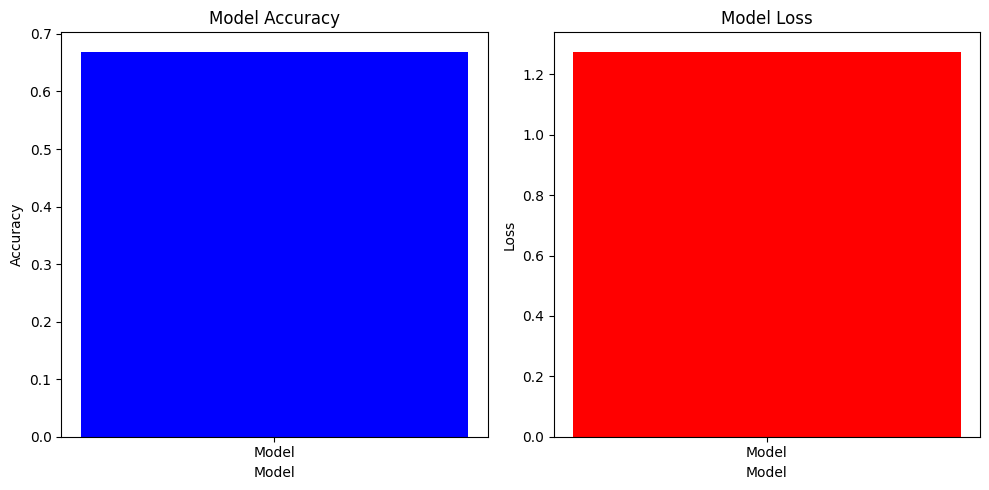

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have already evaluated your model
evaluation_metrics = model.evaluate(dev_dataset)
loss_value = evaluation_metrics[0]
accuracy_value = evaluation_metrics[1]

# Storing the metrics in a dictionary
metrics_dict = {'Loss': [loss_value], 'Accuracy': [accuracy_value]}

# Create a DataFrame
df = pd.DataFrame(metrics_dict, index=['Model'])

# Display the DataFrame as a table
print(df)

# Plotting
plt.figure(figsize=(10, 5))

# Plot for Accuracy
plt.subplot(1, 2, 1)
plt.bar(df.index, df['Accuracy'], color='blue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

# Plot for Loss
plt.subplot(1, 2, 2)
plt.bar(df.index, df['Loss'], color='red')
plt.xlabel('Model')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()


       Model      Loss  Accuracy
0  YourModel  1.275136  0.669334


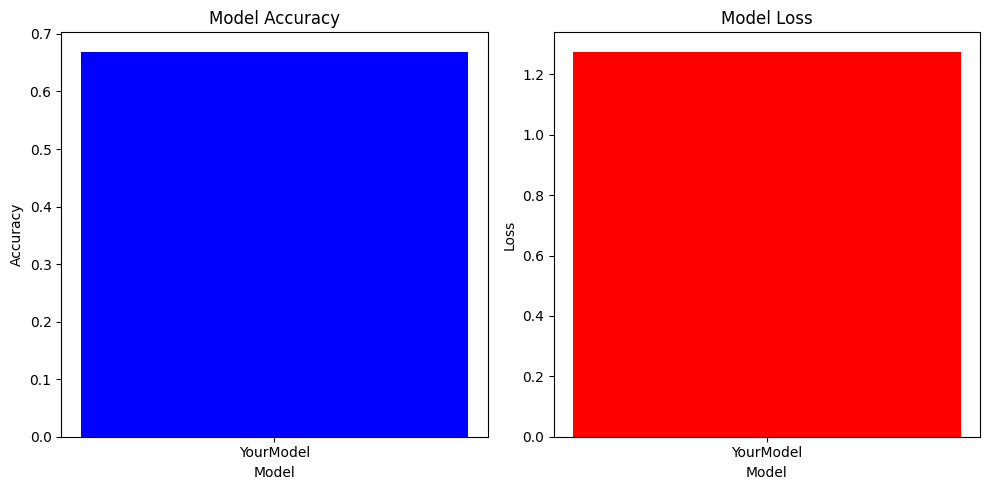

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example data
evaluation_metrics = {'Model': ['YourModel'],
                      'Loss': [evaluation_metrics[0]],
                      'Accuracy': [evaluation_metrics[1]]}

# Create a DataFrame
df = pd.DataFrame(evaluation_metrics)

# Display the DataFrame as a table
print(df)

# Plotting
plt.figure(figsize=(10, 5))

# Plot for Accuracy
plt.subplot(1, 2, 1)
plt.bar(df['Model'], df['Accuracy'], color='blue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

# Plot for Loss
plt.subplot(1, 2, 2)
plt.bar(df['Model'], df['Loss'], color='red')
plt.xlabel('Model')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()


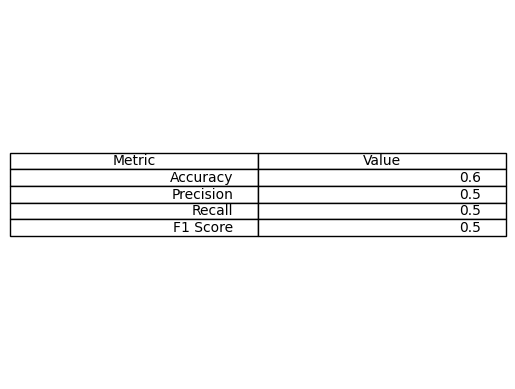

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming y_true contains the true labels and y_pred contains the predicted labels
# Replace these with your actual data
y_true = [0, 1, 0, 1, 0]  # Example true labels
y_pred = [0, 1, 0, 0, 1]  # Example predicted labels

# Compute accuracy measures
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Create a DataFrame for visualization
accuracy_measures = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [accuracy, precision, recall, f1]
})

# Plot the DataFrame as a table
fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
ax.table(cellText=accuracy_measures.values, colLabels=accuracy_measures.columns, loc='center')

plt.show()


In [ ]:
#saving model weights
# Save model weights
model.save_weights('my_model_weights.h5')


AttributeError: ignored

In [ ]:
#additional epochs
# Assuming the model architecture is defined as before
# Load the saved weights
model.load_weights('my_model_weights.h5')

# Continue training for more epochs
additional_epochs = 2  # or however many more you want
model.fit(
    train_dataset,
    initial_epoch=epochs,  # start from the next epoch
    epochs=epochs + additional_epochs,
    validation_data=dev_dataset,
    callbacks=[progress_callback],
    verbose=0  # Set to 0 to prevent the default progress bar
)

# Evaluate the model again
evaluation_metrics = model.evaluate(dev_dataset)
print(f"\nEvaluation Results - Loss: {evaluation_metrics[0]}, Accuracy: {evaluation_metrics[1]}")


Streaming output truncated to the last 5000 lines.
Epoch Progress: Batch 1526/3258 (Remaining: 1732), Loss: 0.1050, Accuracy: 0.9609
Epoch Progress: Batch 1527/3258 (Remaining: 1731), Loss: 0.1050, Accuracy: 0.9610
Epoch Progress: Batch 1528/3258 (Remaining: 1730), Loss: 0.1049, Accuracy: 0.9610
Epoch Progress: Batch 1529/3258 (Remaining: 1729), Loss: 0.1049, Accuracy: 0.9610
Epoch Progress: Batch 1530/3258 (Remaining: 1728), Loss: 0.1049, Accuracy: 0.9610
Epoch Progress: Batch 1531/3258 (Remaining: 1727), Loss: 0.1048, Accuracy: 0.9611
Epoch Progress: Batch 1532/3258 (Remaining: 1726), Loss: 0.1049, Accuracy: 0.9610
Epoch Progress: Batch 1533/3258 (Remaining: 1725), Loss: 0.1050, Accuracy: 0.9609
Epoch Progress: Batch 1534/3258 (Remaining: 1724), Loss: 0.1050, Accuracy: 0.9610
Epoch Progress: Batch 1535/3258 (Remaining: 1723), Loss: 0.1049, Accuracy: 0.9610
Epoch Progress: Batch 1536/3258 (Remaining: 1722), Loss: 0.1049, Accuracy: 0.9610
Epoch Progress: Batch 1537/3258 (Remaining: 172

Cross Validation Score: [0.6625 0.6625 0.6625 0.6625 0.65  ]
Accuracy: 0.68
              precision    recall  f1-score   support

           0       1.00      0.03      0.06        33
           1       0.68      1.00      0.81        67

    accuracy                           0.68       100
   macro avg       0.84      0.52      0.43       100
weighted avg       0.78      0.68      0.56       100



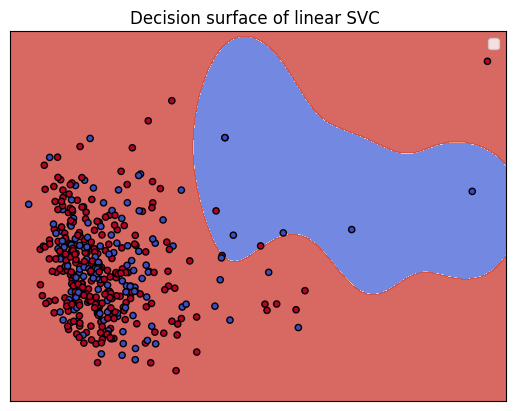

In [ ]:
#SVM
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn import svm
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load the dataset
squad_v2 = load_dataset("squad_v2")

# Initialize the tokenizer and model from HuggingFace Transformers
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
mmodel = BertModel.from_pretrained('bert-base-uncased')

# Function to encode and extract embeddings for the dataset
def encode_and_extract_embeddings(dataset, batch_size=16):
    # Use the GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    mmodel.to(device)

    embeddings = []
    for i in range(0, len(dataset), batch_size):
        batch = dataset[i:i+batch_size]
        contexts = [entry['context'] for entry in batch]
        questions = [entry['question'] for entry in batch]
        # Tokenize and encode the batch
        inputs = tokenizer(contexts, questions, padding=True, truncation=True, max_length=512, return_tensors="pt")
        inputs = inputs.to(device)

        # Get BERT embeddings
        with torch.no_grad():
            outputs = mmodel(**inputs)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

# Create labels
labels = [1 if entry['answers']['text'] else 0 for entry in squad_v2['train']]

# We'll use a smaller portion of the data to avoid memory issues
# Convert numpy.int64 indices to native Python ints
sample_indices = [int(i) for i in np.random.choice(len(squad_v2['train']), size=500, replace=False)]

# Now it's safe to use these indices to sample the dataset
sampled_dataset = [squad_v2['train'][i] for i in sample_indices]
sampled_labels = [labels[i] for i in sample_indices]


# Extract embeddings for the sampled data
embeddings = encode_and_extract_embeddings(sampled_dataset)

# Apply PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(reduced_embeddings, sampled_labels, test_size=0.2, random_state=42)

# Initialize random forest
clf = svm.SVC(kernel='rbf')

#train random forest
clf.fit(X_train, y_train)

#test forest
y_pred = clf.predict(X_test)

# Evaluate the model
print("Cross Validation Score:", cross_val_score(clf, X_train, y_train))
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = X_train[:, 0], X_train[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
ax.legend()
plt.show()

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


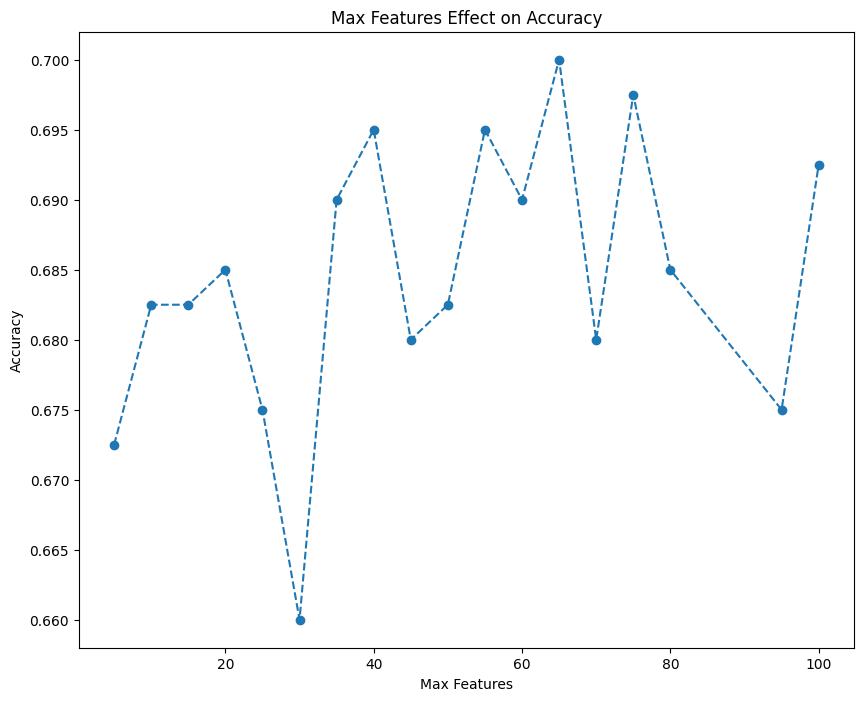

In [ ]:
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import torch
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
squad_v2 = load_dataset("squad_v2")

# Initialize the tokenizer and model from HuggingFace Transformers
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
modell = BertModel.from_pretrained('bert-base-uncased')

# Function to encode and extract embeddings for the dataset
def encode_and_extract_embeddings(dataset, batch_size=16):
    # Use the GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    modell.to(device)

    embeddings = []
    for i in range(0, len(dataset), batch_size):
        batch = dataset[i:i+batch_size]
        contexts = [entry['context'] for entry in batch]
        questions = [entry['question'] for entry in batch]
        # Tokenize and encode the batch
        inputs = tokenizer(contexts, questions, padding=True, truncation=True, max_length=512, return_tensors="pt")
        inputs = inputs.to(device)

        # Get BERT embeddings
        with torch.no_grad():
            outputs = modell(**inputs)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

# Create labels
labels = [1 if entry['answers']['text'] else 0 for entry in squad_v2['train']]

# We'll use a smaller portion of the data to avoid memory issues
# Convert numpy.int64 indices to native Python ints
sample_indices = [int(i) for i in np.random.choice(len(squad_v2['train']), size=2000, replace=False)]

# Now it's safe to use these indices to sample the dataset
sampled_dataset = [squad_v2['train'][i] for i in sample_indices]
sampled_labels = [labels[i] for i in sample_indices]


# Extract embeddings for the sampled data
embeddings = encode_and_extract_embeddings(sampled_dataset)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(embeddings, sampled_labels, test_size=0.2, random_state=42)

#Initialize list of max features to test
max_features_list = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,95,100]

results = []
#test different max features
for max_features in max_features_list:

  # Initialize random forest
  clf_rf = RandomForestClassifier(max_depth=max_features, max_features=max_features)

  #train random forest
  clf_rf.fit(X_train, y_train)

  #test forest
  y_pred = clf_rf.predict(X_test)

  # Evaluate the model
  results.append(accuracy_score(y_test, y_pred))
plt.figure(figsize=(10, 8))
plt.plot(max_features_list, results, linestyle='dashed', marker="o")  # increased size
plt.title('Max Features Effect on Accuracy')
plt.xlabel('Max Features')
plt.ylabel('Accuracy')
plt.show()


In [ ]:

def encode_and_extract_embeddings(tokenized_data):
    # Initialize the model
    modelll = BertModel.from_pretrained('bert-base-uncased')
    modelll.to('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available

    embeddings = []
    for entry in tokenized_data:
        # Extract input fields
        input_ids = torch.tensor([entry['input_ids']])
        attention_mask = torch.tensor([entry['attention_mask']])
        token_type_ids = torch.tensor([entry['token_type_ids']])

        # Move tensors to the same device as the model
        input_ids = input_ids.to(modelll.device)
        attention_mask = attention_mask.to(modelll.device)
        token_type_ids = token_type_ids.to(modelll.device)

        # Get BERT embeddings
        with torch.no_grad():
            outputs = modelll(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        # Use the pooled output for embeddings
        batch_embeddings = outputs.pooler_output.cpu().numpy()
        embeddings.extend(batch_embeddings)

    return np.vstack(embeddings)

In [ ]:
print(X_val_meta[:5])


[{'input_ids': array([  101,  2054,  2103,  2003, 12418,  1005,  1055,  5135,  4322,
        1999,  1029,   102, 12418,  4128,  1999,  1996,  2142,  2163,
        2024,  2284,  1999,  5899,  1010,  3146,  1025,  2933,  2080,
        1010,  3146,  1025, 10594,  6692,  1010,  2047,  7035,  1025,
        8423,  1010,  5298,  1025,  5858,  2103,  1010,  5858,  1025,
       21877, 11069,  1010,  4307,  1025,  4564, 12691,  1010,  5392,
        1006,  6734,  2181,  1007,  1025, 10180,  1011, 10389,  1010,
        2167,  3792,  1025, 10267, 10996,  1010,  5135,  1006, 12418,
        4012, 11880, 16136,  1007,  1025,  9116,  2665,  1010,  5612,
        1025,  5367,  1010,  8506,  1025,  1998,  5631,  1010,  3516,
        1012,  4128,  2284,  6917,  2421, 21812,  1010,  6027,  1025,
        8418, 27245,  1010,  2859,  1025, 11655,  3600,  9091,  1010,
        2866,  1025,  9011,  1010,  5137, 12249,  1010,  2634,  1025,
       13624,  1010,  2634,  1025,  2053,  8524,  1010,  2634,  1025,
     

In [ ]:
#Ensemble
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import accuracy_score

# 1. Split data for training base models and meta-model
# Assuming tokenized_train contains your input data and labels
#X_train_base, X_val_meta, y_train_base, y_val_meta = train_test_split(
    #tokenized_train, [x['label'] for x in tokenized_train], test_size=0.2, random_state=42
#)


#nn_predictions = model.predict(convert_to_tf_dataset(X_val_meta, batch_size=8))
#svm_predictions = clf.predict(encode_and_extract_embeddings(X_val_meta))
rf_predictions = clf_rf.predict(encode_and_extract_embeddings(X_val_meta))

# Combine predictions for meta-model training
X_meta_train = np.column_stack((nn_predictions.ravel(), svm_predictions, rf_predictions))

# 6. Train Meta-Model
meta_model = LogisticRegression()
meta_model.fit(X_meta_train, [x['label'] for x in X_val_meta])

# 7. Prepare Test Data
# Assuming tokenized_dev is your test data
X_test_nn = convert_to_tf_dataset(tokenized_dev, batch_size=8)
X_test_rf_svm = encode_and_extract_embeddings(tokenized_dev)

# 8. Generate Predictions on Test Data
nn_test_predictions = model.predict(X_test_nn)
svm_test_predictions = clf.predict(X_test_rf_svm)
rf_test_predictions = clf_rf.predict(X_test_rf_svm)

# Combine predictions for final evaluation
X_meta_test = np.column_stack((nn_test_predictions.ravel(), svm_test_predictions, rf_test_predictions))

# 9. Final Predictions from Meta-Model
final_predictions = meta_model.predict(X_meta_test)

# 10. Evaluate Performance
print("Accuracy:", accuracy_score([x['label'] for x in tokenized_dev], final_predictions))


297/297 [==============================] - 73s 244ms/step
Accuracy: 0.6638584667228307


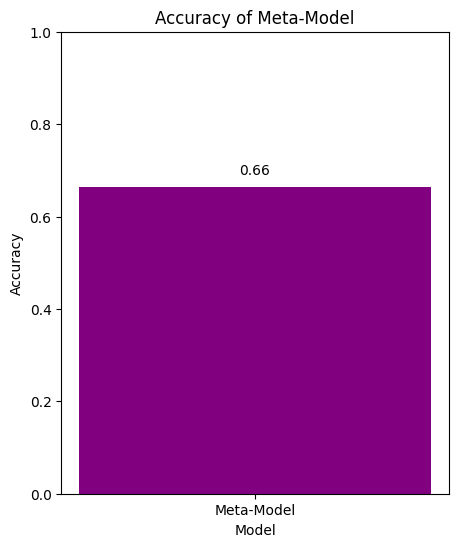

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Your existing code...

# Compute accuracies
threshold = 0.5

# Convert probabilities to binary class labels
nn_binary_predictions = (nn_test_predictions.ravel() > threshold).astype(int)

# Compute accuracies
nn_accuracy = accuracy_score([x['label'] for x in tokenized_dev], nn_binary_predictions)
svm_accuracy = accuracy_score([x['label'] for x in tokenized_dev], svm_test_predictions)
rf_accuracy = accuracy_score([x['label'] for x in tokenized_dev], rf_test_predictions)
meta_model_accuracy = accuracy_score([x['label'] for x in tokenized_dev], final_predictions)

# Data for plotting
model = 'Meta-Model'
accuracy = meta_model_accuracy

# Plotting
plt.figure(figsize=(5, 6))
plt.bar(model, accuracy, color='purple')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Meta-Model')
plt.ylim([0, 1])  # Assuming accuracy is between 0 and 1
plt.text(0, accuracy + 0.02, f"{accuracy:.2f}", ha='center', va='bottom')
plt.show()


In [ ]:
print(tokenized_train[0])

{'input_ids': array([  101,  2043,  2106, 20773,  2707,  3352,  2759,  1029,   102,
       20773, 21025, 19358, 22815,  1011,  5708,  1006,  1013, 12170,
       23432, 29715,  3501, 29678, 12325, 29685,  1013, 10506,  1011,
       10930,  2078,  1011,  2360,  1007,  1006,  2141,  2244,  1018,
        1010,  3261,  1007,  2003,  2019,  2137,  3220,  1010,  6009,
        1010,  2501,  3135,  1998,  3883,  1012,  2141,  1998,  2992,
        1999,  5395,  1010,  3146,  1010,  2016,  2864,  1999,  2536,
        4823,  1998,  5613,  6479,  2004,  1037,  2775,  1010,  1998,
        3123,  2000,  4476,  1999,  1996,  2397,  4134,  2004,  2599,
        3220,  1997,  1054,  1004,  1038,  2611,  1011,  2177, 10461,
        1005,  1055,  2775,  1012,  3266,  2011,  2014,  2269,  1010,
       25436, 22815,  1010,  1996,  2177,  2150,  2028,  1997,  1996,
        2088,  1005,  1055,  2190,  1011,  4855,  2611,  2967,  1997,
        2035,  2051,  1012,  2037, 14221,  2387,  1996,  2713,  1997,
      

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam


# Clear any previous session information
tf.keras.backend.clear_session()

# Set your parameters
vocab_size = 30522  # Adjust based on your tokenizer's vocabulary size
embedding_dim = 64  # Dimension of token embeddings
max_length = 512    # Maximum length of input sequences
lstm_units = 64     # Number of units in LSTM layers

# Define the model architecture
input_ids = Input(shape=(max_length,), dtype='int32', name='input_ids')
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)(input_ids)
x = Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=0.3))(embedding)  # Adding dropout
x = Bidirectional(LSTM(lstm_units, dropout=0.3))(x)
output = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

model = Model(inputs=input_ids, outputs=output)

learning_rate = 0.01  # Example learning rate, adjust as needed

# Create an Adam optimizer with the set learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the custom optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])



# Print model summary
model.summary()

# Convert data to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': np.array([x['input_ids'] for x in tokenized_train]),
        'attention_mask': np.array([x['attention_mask'] for x in tokenized_train]),
        'token_type_ids': np.array([x['token_type_ids'] for x in tokenized_train])  # Include this line only if you're using token_type_ids
    },
    np.array([x['label'] for x in tokenized_train])
))

dev_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': np.array([x['input_ids'] for x in tokenized_dev]),
        'attention_mask': np.array([x['attention_mask'] for x in tokenized_dev]),
        'token_type_ids': np.array([x['token_type_ids'] for x in tokenized_dev])  # Include this line only if you're using token_type_ids
    },
    np.array([x['label'] for x in tokenized_dev])
))

# Shuffle and batch the datasets
train_dataset = train_dataset.shuffle(len(tokenized_train)).batch(32)
dev_dataset = dev_dataset.batch(32)



# Train the model
history = model.fit(train_dataset, epochs=2, validation_data=dev_dataset)

# Evaluate the model
model.evaluate(dev_dataset)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 512)]             0         
                                                                 
 embedding (Embedding)       (None, 512, 64)           1953408   
                                                                 
 bidirectional (Bidirection  (None, 512, 128)          66048     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2118401 (8.08 MB)
Trainable params: 2118401 (8.

[1.0213736295700073, 0.5392908453941345]

In [ ]:
import pandas as pd

# Extracting accuracy data from the history object
epochs = range(1, len(history.history['answerable_accuracy']) + 1)
train_answerable_acc = history.history['answerable_accuracy']
val_answerable_acc = history.history['val_answerable_accuracy']

# Creating a DataFrame
accuracy_df = pd.DataFrame({
    'Epoch': epochs,
    'Train Answerable Accuracy': train_answerable_acc,
    'Val Answerable Accuracy': val_answerable_acc
})

# Displaying the DataFrame
print(accuracy_df)


   Epoch  Train Start Pos Accuracy  Train End Pos Accuracy  \
0      1                  0.334786                0.333674   
1      2                  0.341009                0.335630   
2      3                  0.343948                0.337027   
3      4                  0.345000                0.337932   
4      5                  0.346381                0.339406   

   Val Start Pos Accuracy  Val End Pos Accuracy  
0                0.492462              0.500547  
1                0.420450              0.453971  
2                0.402763              0.413712  
3                0.391140              0.407563  
4                0.383812              0.397541  


In [ ]:
print(history.history.keys())


dict_keys(['loss', 'start_positions_loss', 'end_positions_loss', 'start_positions_accuracy', 'end_positions_accuracy', 'val_loss', 'val_start_positions_loss', 'val_end_positions_loss', 'val_start_positions_accuracy', 'val_end_positions_accuracy'])


In [ ]:
import tensorflow as tf
import numpy as np
import json
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Bidirectional
from transformers import BertTokenizerFast

# Function to load the dataset
def load_squad(path):
    with open(path, 'r') as file:
        squad_data = json.load(file)
    return squad_data

# Tokenization function
def tokenize_squad_1_1(data, tokenizer):
    tokenized_data = []
    for article in data['data']:
        for paragraph in article['paragraphs']:
            context = paragraph['context']
            for qa in paragraph['qas']:
                question = qa['question']
                # Tokenize context and question
                tokenized_example = tokenizer.encode_plus(question, context, max_length=512, truncation='only_second', padding='max_length', return_tensors='tf', return_offsets_mapping=True)
                offset_mapping = tokenized_example['offset_mapping'].numpy()[0]

                # Initialize token start and end positions
                token_start_index, token_end_index = 0, 0
                if 'answers' in qa and len(qa['answers']) > 0:
                    answer = qa['answers'][0]
                    start_char = answer['answer_start']
                    end_char = start_char + len(answer['text'])
                    for i, (start, end) in enumerate(offset_mapping):
                        if start <= start_char and end >= start_char:
                            token_start_index = i
                        if start <= end_char and end >= end_char:
                            token_end_index = i
                            break

                tokenized_data.append({
                    'input_ids': tokenized_example['input_ids'].numpy()[0],
                    'start_positions': token_start_index,
                    'end_positions': token_end_index
                })
    return tokenized_data

# Initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Load training and development data
squad_train = load_squad('squad_train_v2.json')
squad_dev = load_squad('squad_dev_v2.json')

# Tokenize datasets
tokenized_train = tokenize_squad_1_1(squad_train, tokenizer)
tokenized_dev = tokenize_squad_1_1(squad_dev, tokenizer)

# Clear any previous session information
tf.keras.backend.clear_session()

# Model parameters
vocab_size = 30522  # Adjust based on your tokenizer's vocabulary size
embedding_dim = 64  # Dimension of token embeddings
max_length = 512    # Maximum length of input sequences
lstm_units = 64     # Number of units in LSTM layers

# Define the model architecture
input_ids = Input(shape=(max_length,), dtype='int32', name='input_ids')
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)(input_ids)
lstm = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding)
output_start = Dense(max_length, activation='softmax', name='start_positions')(lstm)
output_end = Dense(max_length, activation='softmax', name='end_positions')(lstm)

model = Model(inputs=input_ids, outputs=[output_start, output_end])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Prepare the datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': np.array([x['input_ids'] for x in tokenized_train])},
    {'start_positions': np.array([x['start_positions'] for x in tokenized_train]),
     'end_positions': np.array([x['end_positions'] for x in tokenized_train])}
))

dev_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': np.array([x['input_ids'] for x in tokenized_dev])},
    {'start_positions': np.array([x['start_positions'] for x in tokenized_dev]),
     'end_positions': np.array([x['end_positions'] for x in tokenized_dev])}
))

# Shuffle and batch the datasets
train_dataset = train_dataset.shuffle(len(tokenized_train)).batch(32)
dev_dataset = dev_dataset.batch(32)

# Train the model
history = model.fit(train_dataset, epochs=5, validation_data=dev_dataset)

# Evaluate the model
model.evaluate(dev_dataset)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 512, 64)              1953408   ['input_ids[0][0]']           
                                                                                                  
 bidirectional (Bidirection  (None, 512, 128)             66048     ['embedding[0][0]']           
 al)                                                                                              
                                                                                                  
 start_positions (Dense)     (None, 512, 512)             66048     ['bidirectional[0][0]']   

InvalidArgumentError: ignored

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Bidirectional

# Clear any previous session information
tf.keras.backend.clear_session()

# Model parameters
vocab_size = 30522  # Adjust based on your tokenizer's vocabulary size
embedding_dim = 64  # Dimension of token embeddings
max_length = 512    # Maximum length of input sequences
lstm_units = 64     # Number of units in LSTM layers

# Define the model architecture
input_ids = Input(shape=(max_length,), dtype='int32', name='input_ids')
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)(input_ids)
lstm = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding)
output_start = Dense(1, activation='softmax', name='start_positions')(lstm)
output_end = Dense(1, activation='softmax', name='end_positions')(lstm)

model = Model(inputs=input_ids, outputs=[output_start, output_end])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Prepare the datasets
def reshape_labels(tokenized_data):
    start_positions = np.array([x['start_positions'] for x in tokenized_data])
    end_positions = np.array([x['end_positions'] for x in tokenized_data])
    # Reshape to 2D tensors (batch_size, sequence_length)
    start_positions = np.expand_dims(start_positions, axis=-1)
    end_positions = np.expand_dims(end_positions, axis=-1)
    return start_positions, end_positions

train_start_positions, train_end_positions = reshape_labels(tokenized_train)
dev_start_positions, dev_end_positions = reshape_labels(tokenized_dev)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': np.array([x['input_ids'] for x in tokenized_train])}, {'start_positions': train_start_positions, 'end_positions': train_end_positions}))
dev_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': np.array([x['input_ids'] for x in tokenized_dev])}, {'start_positions': dev_start_positions, 'end_positions': dev_end_positions}))

# Shuffle and batch the datasets
train_dataset = train_dataset.shuffle(len(tokenized_train)).batch(32)
dev_dataset = dev_dataset.batch(32)

# Train the model
history = model.fit(train_dataset, epochs=3, validation_data=dev_dataset)

# Evaluate the model
model.evaluate(dev_dataset)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 512, 64)              1953408   ['input_ids[0][0]']           
                                                                                                  
 bidirectional (Bidirection  (None, 512, 128)             66048     ['embedding[0][0]']           
 al)                                                                                              
                                                                                                  
 start_positions (Dense)     (None, 512, 1)               129       ['bidirectional[0][0]']   

KeyboardInterrupt: ignored

In [ ]:
def tokenize_squad_answerable(data, tokenizer):
    tokenized_data = []
    for article in data['data']:
        for paragraph in article['paragraphs']:
            context = paragraph['context']
            for qa in paragraph['qas']:
                # Process only if answers are provided
                if 'answers' in qa and len(qa['answers']) > 0:
                    question = qa['question']
                    tokenized_example = tokenizer.encode_plus(question, context, max_length=512, truncation='only_second', padding='max_length', return_tensors='tf', return_offsets_mapping=True)
                    offset_mapping = tokenized_example['offset_mapping'].numpy()[0]

                    # Find start and end positions of the answer
                    answer = qa['answers'][0]
                    start_char = answer['answer_start']
                    end_char = start_char + len(answer['text'])

                    token_start_index, token_end_index = 0, 0
                    for i, (start, end) in enumerate(offset_mapping):
                        if start <= start_char and end >= start_char:
                            token_start_index = i
                        if start <= end_char and end >= end_char:
                            token_end_index = i
                            break

                    tokenized_data.append({
                        'input_ids': tokenized_example['input_ids'].numpy()[0],
                        'start_positions': token_start_index,
                        'end_positions': token_end_index
                    })
    return tokenized_data

# Use this function instead to tokenize the data
tokenized_train = tokenize_squad_answerable(squad_train, tokenizer)
tokenized_dev = tokenize_squad_answerable(squad_dev, tokenizer)


In [ ]:

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Bidirectional, Dropout, concatenate

import numpy as np


from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.metrics import SparseCategoricalAccuracy, Mean


# Clear any previous session information
tf.keras.backend.clear_session()

# Model parameters
vocab_size = 30522  # Based on your tokenizer's vocabulary size
embedding_dim = 128  # Increased embedding dimension
max_length = 512    # Maximum length of input sequences
lstm_units = 128    # Increased number of units in LSTM layers

# Define a more complex model architecture
input_ids = Input(shape=(max_length,), dtype='int32', name='input_ids')
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)(input_ids)

# First BiLSTM layer
lstm1 = Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=0.3))(embedding)
# Second BiLSTM layer
lstm2 = Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=0.3))(lstm1)

# Concatenating the outputs of both LSTM layers
concatenated = concatenate([lstm1, lstm2])

# Fully connected layers
dense1 = Dense(512, activation='relu')(concatenated)
dropout = Dropout(0.4)(dense1)
output_start = Dense(max_length, activation='softmax', name='start_positions')(dropout)
output_end = Dense(max_length, activation='softmax', name='end_positions')(dropout)

model = Model(inputs=input_ids, outputs=[output_start, output_end])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 512, 128)             3906816   ['input_ids[0][0]']           
                                                                                                  
 bidirectional (Bidirection  (None, 512, 256)             263168    ['embedding[0][0]']           
 al)                                                                                              
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 512, 256)             394240    ['bidirectional[0][0]']   

In [ ]:



# Clear any previous session information
tf.keras.backend.clear_session()

# Model parameters
vocab_size = 30522  # Based on your tokenizer's vocabulary size
embedding_dim = 64  # Dimension of token embeddings
max_length = 512    # Maximum length of input sequences
lstm_units = 64     # Number of units in LSTM layers

# Define the model architecture for question-answering
input_ids = Input(shape=(max_length,), dtype='int32', name='input_ids')
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)(input_ids)
lstm = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding)
lstm = GlobalAveragePooling1D()(lstm)  # Collapse the sequence dimension
output_start = Dense(max_length, activation='softmax', name='start_positions')(lstm)
output_end = Dense(max_length, activation='softmax', name='end_positions')(lstm)

model = Model(inputs=input_ids, outputs=[output_start, output_end])

# Assuming tokenized_train and tokenized_dev are correctly prepared
train_input_ids = np.array([x['input_ids'] for x in tokenized_train])
train_start_positions = np.array([x['start_positions'] for x in tokenized_train])
train_end_positions = np.array([x['end_positions'] for x in tokenized_train])

dev_input_ids = np.array([x['input_ids'] for x in tokenized_dev])
dev_start_positions = np.array([x['start_positions'] for x in tokenized_dev])
dev_end_positions = np.array([x['end_positions'] for x in tokenized_dev])

# Prepare the datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    train_input_ids,
    {'start_positions': train_start_positions, 'end_positions': train_end_positions}
)).shuffle(len(train_input_ids)).batch(32)

dev_dataset = tf.data.Dataset.from_tensor_slices((
    dev_input_ids,
    {'start_positions': dev_start_positions, 'end_positions': dev_end_positions}
)).batch(32)

# Custom Training Loop
epochs = 3
new_learning_rate = 0.1  # Adjust this value as needed

optimizer = tf.keras.optimizers.Adam(learning_rate=new_learning_rate)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy_start = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy_start')
train_accuracy_end = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy_end')
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    for step, (inputs, targets) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            predictions = model(inputs, training=True)
            loss_start = loss_object(targets['start_positions'], predictions[0])
            loss_end = loss_object(targets['end_positions'], predictions[1])
            loss = loss_start + loss_end

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # Update the metrics
        train_loss(loss)
        train_accuracy_start.update_state(targets['start_positions'], predictions[0])
        train_accuracy_end.update_state(targets['end_positions'], predictions[1])

        # Print the metrics for each step
        print(f"Step {step + 1}, "
              f"Loss: {train_loss.result()}, "
              f"Start Accuracy: {train_accuracy_start.result()}, "
              f"End Accuracy: {train_accuracy_end.result()}")

    # Reset the metrics at the end of each epoch
    train_loss.reset_states()
    train_accuracy_start.reset_states()
    train_accuracy_end.reset_states()



# Evaluate the model
model.evaluate(dev_dataset)


Epoch 1/3
Step 1, Loss: 12.477352142333984, Start Accuracy: 0.0, End Accuracy: 0.0
Step 2, Loss: 12.389568328857422, Start Accuracy: 0.015625, End Accuracy: 0.0
Step 3, Loss: 12.564099311828613, Start Accuracy: 0.010416666977107525, End Accuracy: 0.0
Step 4, Loss: 12.56091594696045, Start Accuracy: 0.0078125, End Accuracy: 0.015625
Step 5, Loss: 12.53100872039795, Start Accuracy: 0.0062500000931322575, End Accuracy: 0.012500000186264515
Step 6, Loss: 12.676570892333984, Start Accuracy: 0.0052083334885537624, End Accuracy: 0.010416666977107525
Step 7, Loss: 13.07932186126709, Start Accuracy: 0.004464285913854837, End Accuracy: 0.008928571827709675
Step 8, Loss: 13.567094802856445, Start Accuracy: 0.00390625, End Accuracy: 0.01171875
Step 9, Loss: 13.898491859436035, Start Accuracy: 0.0034722222480922937, End Accuracy: 0.013888888992369175
Step 10, Loss: 14.299221992492676, Start Accuracy: 0.0031250000465661287, End Accuracy: 0.012500000186264515
Step 11, Loss: 14.552932739257812, Start 

KeyboardInterrupt: ignored

In [ ]:
print(train_start_positions.shape)  # Expected: (num_examples,)
print(train_end_positions.shape)    # Expected: (num_examples,)


(86821,)
(86821,)


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Generate predictions for the validation dataset
y_pred_proba = model.predict(dev_dataset).ravel()  # Get the probabilities

# Extract true labels from the validation dataset
y_true = np.concatenate([y for x, y in dev_dataset], axis=0)  # Assuming labels are in the second element

# Compute ROC curve data
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)  # Compute the AUC

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


AttributeError: ignored